# Classifying Emotions, Berlin database of Emotional Speech - Project Developement

#### Import libraries and data

In [1]:
!PYTHONHASHSEED=0
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
import numpy as np
import random as python_random
import librosa
import librosa.display
from scipy.signal import butter, filtfilt
import soundfile as sf
from scipy.fft import fft
from scipy.signal import spectrogram
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize, scale
import seaborn as sns
import os
import shutil
from collections import defaultdict
from tqdm import tqdm
from IPython.display import Audio
from itertools import cycle

np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

In [2]:
# function to set a fixed seed
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [3]:
# drive mounting
from google.colab import drive
drive.mount('/content/gdrive')

# files extraction
t0 = time()
copyfile('gdrive/My Drive/FDL_Project_Genuardi_Noè/download.zip', 'download.zip')
zip_file = zipfile.ZipFile('download.zip')
zip_file.extractall()
zip_file.close()
print("File transfer completed in %0.3f seconds" % (time() - t0))

# removing unusefull directories
shutil.rmtree('labsilb')
shutil.rmtree('lablaut')
shutil.rmtree('silb')

Mounted at /content/gdrive
File transfer completed in 1.852 seconds


## 1. Pre-processing

- person is identified with the two first numbers: 03, 08, 09, 10, 11, 12, 13, 14, 15, 16 (10 speakers, 5 male, 5 female)
- the code (letter and number) in the middle represents the spoken sentence
- emotion is identified with the second to last letter (encoded in german):
 - W  (Wut): anger
 - L	(Langeweile): boredom
 - E  (Ekel): disgust
 - A  (Angst): anxiety/fear
 - F  (Freude): happiness
 - T  (Trauer): sadness
- the last letter corresponds to the file version

### Preliminar Data Exploration

In [4]:
# organize by emotion
emotion_map = {
    'W': 'anger',
    'L': 'boredom',
    'E': 'disgust',
    'A': 'fear',
    'F': 'happiness',
    'T': 'sadness',
    'N': 'neutral'
}

label_map = {'anger': 0,
    'boredom': 1,
    'disgust': 2,
    'fear': 3,
    'happiness': 4,
    'sadness': 5,
    'neutral': 6}

In [5]:
# class balance check
counts = {}

for filename in os.listdir('wav/'):
    if filename.endswith('.wav'):
        emotion_code = filename[5]
        emotion = emotion_map.get(emotion_code)
        if emotion:
            if emotion in counts:
                counts[emotion] += 1
            else:
                counts[emotion] = 1

for emotion, count in counts.items():
    print(f"{emotion}: {count}")

anger: 127
happiness: 71
sadness: 62
fear: 69
boredom: 81
disgust: 46
neutral: 79


In [6]:
# a look at files per speaker and file lengths
speaker_dict = defaultdict(list)

min_length = 99999999
min_file = ''
max_length = 0
max_file = ''
counter = 0

for file in os.listdir('wav'):

  if not file.endswith(".wav"):
    continue

  speaker_id = file[:2]
  speaker_dict[speaker_id].append(file)

  in_path = os.path.join('wav', file)
  y, sr = librosa.load(in_path, sr=None)
  if (len(y)>24000) & (len(y) < 54000):
    counter += 1
  if len(y) < min_length:
    min_length = len(y)
    min_file = file
  if len(y) > max_length:
    max_length = len(y)
    max_file = file

In [7]:
# files per speaker
for speaker in speaker_dict.keys():
  print(f"Speaker {speaker} has {len(speaker_dict[speaker])} files")

Speaker 03 has 49 files
Speaker 11 has 55 files
Speaker 08 has 58 files
Speaker 14 has 69 files
Speaker 13 has 61 files
Speaker 12 has 35 files
Speaker 10 has 38 files
Speaker 15 has 56 files
Speaker 16 has 71 files
Speaker 09 has 43 files


In [8]:
# audio lengths
print(f"The minimum length of audio files found in the dataset is: {min_length/16000} seconds")
print(f"The shortest audio is in file {min_file}")
print(f"The maximum length of audio files found in the dataset is: {max_length/16000} seconds")
print(f"The longest audio is in file {max_file}")
print(f"And we have {counter} files between 1.5 and 3.5 seconds")

The minimum length of audio files found in the dataset is: 1.2255 seconds
The shortest audio is in file 12a02Ac.wav
The maximum length of audio files found in the dataset is: 8.97825 seconds
The longest audio is in file 08b03Tc.wav
And we have 401 files between 1.5 and 3.5 seconds


### Pre-processing

- resampling
- filtering
- convert input shape

In [9]:
# for filtering
def butter_lowpass_filter(data, cutoff_freq, sample_rate, order=5):
    from scipy.signal import butter, lfilter
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff_freq / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return lfilter(b, a, data)

# to convert shape
def convert_to_model_input(y, target_length=16000):
    # Trim or pad audio to fixed length
    l = len(y)
    if l > target_length:
      diff = l - target_length
      if diff % 2 == 0:
        y = y[diff//2:target_length+diff//2]
      else:
        y = y[diff//2:target_length+diff//2+1]
    elif l < target_length:
      pad_width = target_length - l
      if pad_width % 2 == 0:
        y = np.pad(y, (pad_width//2, pad_width//2))
      else:
        y = np.pad(y, (pad_width//2, pad_width//2 + 1))
    return y

In [10]:
# function for pre-processing
def preprocess_and_save_all(root_dir, out_dir, target_sr, target_length, cutoff_freq):
    os.makedirs(out_dir, exist_ok=True)

    for file in os.listdir(root_dir):
        if not file.endswith(".wav"):
            continue

        in_path = os.path.join(root_dir, file)
        out_path = os.path.join(out_dir, file)

        y, sr = librosa.load(in_path, sr=None)

        if sr != target_sr:
            y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
            sr = target_sr

        y = butter_lowpass_filter(y, cutoff_freq=cutoff_freq, sample_rate=sr)
        y = convert_to_model_input(y, target_length=target_length)

        sf.write(out_path, y, samplerate=sr)

In [11]:
preprocess_and_save_all(
    root_dir="wav",
    out_dir="preprocessed_data",
    target_sr=16000,
    target_length=64000,
    cutoff_freq=4000
)

## 2. Feature Extraction

#### Data Exploration .wav

We're showing data exploration on two audio recorded by the same actor on the same sentence expressing two different emotions to highlight their differences. We're considering the neutral version and the angry version.

In [12]:
# neutral
audio_file_neutral = f"preprocessed_data/03a02Nc.wav"
waveform_n, sampling_rate_n = librosa.load(audio_file_neutral, sr=None)
print(f'Sampling Rate: {sampling_rate_n} Hz')
Audio(waveform_n, rate=sampling_rate_n)

Sampling Rate: 16000 Hz


In [13]:
# anger
audio_file_anger = f"preprocessed_data/03a02Wb.wav"
waveform_w, sampling_rate_w = librosa.load(audio_file_anger, sr=None)
print(f'Sampling Rate: {sampling_rate_w} Hz')
Audio(waveform_w, rate=sampling_rate_w)

Sampling Rate: 16000 Hz


An insight on audio files:
- Amplitude:  intensity of an audio signal at a particular point of time
- which corresponds to the height of the waveform at that instant of time
- Bit depth: how precisely this amplitude value can be defined depends on the bit
- depth of the sample. The digital representation more closely resembles the actual
- continuous sound wave the higher the bit depth. Higher bit depth results better audio quality

In [14]:
# neutral
# amplitude range
amplitude_range_n = np.max(waveform_n) - np.min(waveform_n)
# bit depth from the audio data
audio_data_n, sampling_rate_n = sf.read(audio_file_neutral)
bit_depth_n = audio_data_n.dtype.itemsize

print(f'Amplitude Range: {amplitude_range_n}')
print(f'Bit Depth: {bit_depth_n} bits')

Amplitude Range: 1.8524169921875
Bit Depth: 8 bits


In [15]:
# anger
# amplitude range
amplitude_range_w = np.max(waveform_w) - np.min(waveform_w)
# bit depth from the audio data
audio_data_w, sampling_rate_w = sf.read(audio_file_anger)
bit_depth_w = audio_data_w.dtype.itemsize

print(f'Amplitude Range: {amplitude_range_w}')
print(f'Bit Depth: {bit_depth_w} bits')

Amplitude Range: 1.702972412109375
Bit Depth: 8 bits


<Figure size 800x400 with 0 Axes>

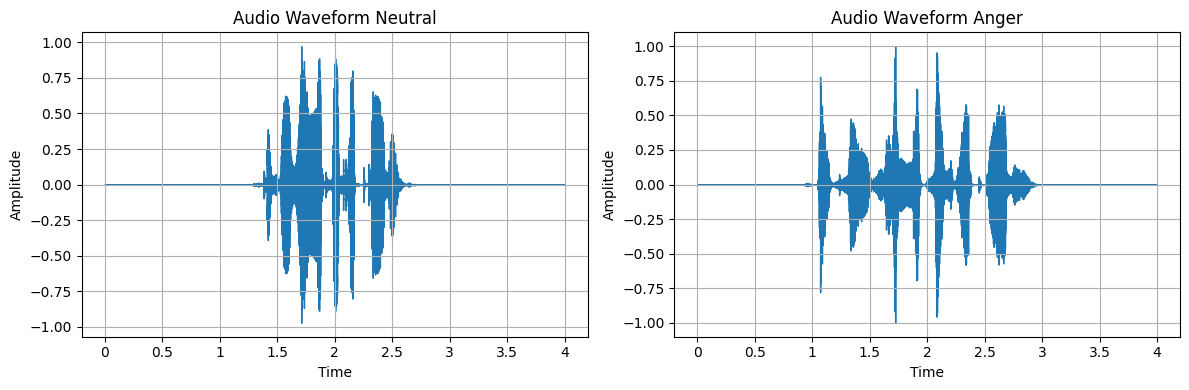

In [16]:
# graphical representation of waveform
plt.figure(figsize=(8, 4))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

librosa.display.waveshow(waveform_n, sr=sampling_rate_n, ax=ax1)
ax1.set_title("Audio Waveform Neutral")
ax1.set_xlabel("Time")
ax1.set_ylabel("Amplitude")
ax1.grid(True)

librosa.display.waveshow(waveform_w, sr=sampling_rate_w, ax=ax2)
ax2.set_title("Audio Waveform Anger")
ax2.set_xlabel("Time")
ax2.set_ylabel("Amplitude")
ax2.grid(True)

plt.tight_layout()
plt.savefig('gdrive/MyDrive/FDL_Project_Genuardi_Noè/Images/NWwaveform.png')
plt.show()

About the spectrum and FFT:
- frequency spectrum: representation of how the energy in an audio signal is distributed across
- different frequencies which can be calculated by applying a mathematical transformation like
- the Fast Fourier Transform (FFT) to the audio signal

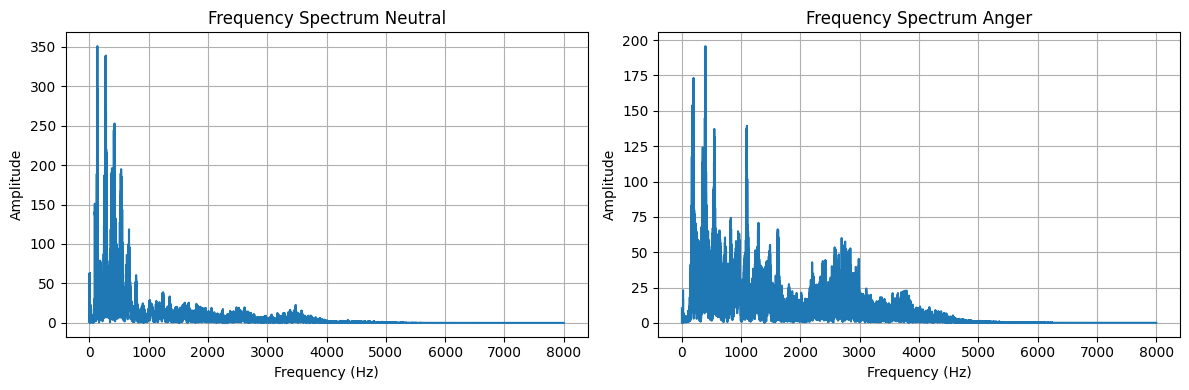

In [17]:
# spectrum visualization
spectrum_n = np.fft.fft(waveform_n)
frequencies_n = np.fft.fftfreq(len(spectrum_n), 1 / sampling_rate_n)

spectrum_w = np.fft.fft(waveform_w)
frequencies_w = np.fft.fftfreq(len(spectrum_w), 1 / sampling_rate_w)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(frequencies_n[:len(frequencies_n)//2], np.abs(spectrum_n[:len(spectrum_n)//2]))
ax1.set_title("Frequency Spectrum Neutral")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Amplitude")
ax1.grid(True)

ax2.plot(frequencies_w[:len(frequencies_w)//2], np.abs(spectrum_w[:len(spectrum_w)//2]))
ax2.set_title("Frequency Spectrum Anger")
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Amplitude")
ax2.grid(True)

plt.tight_layout()
plt.savefig("gdrive/MyDrive/FDL_Project_Genuardi_Noè/Images/NWspectrum.png")
plt.show()

Spectrogram: time-frequency representation of an audio signal which provides a 2D visualization of how the frequency content of the audio signal changes over time

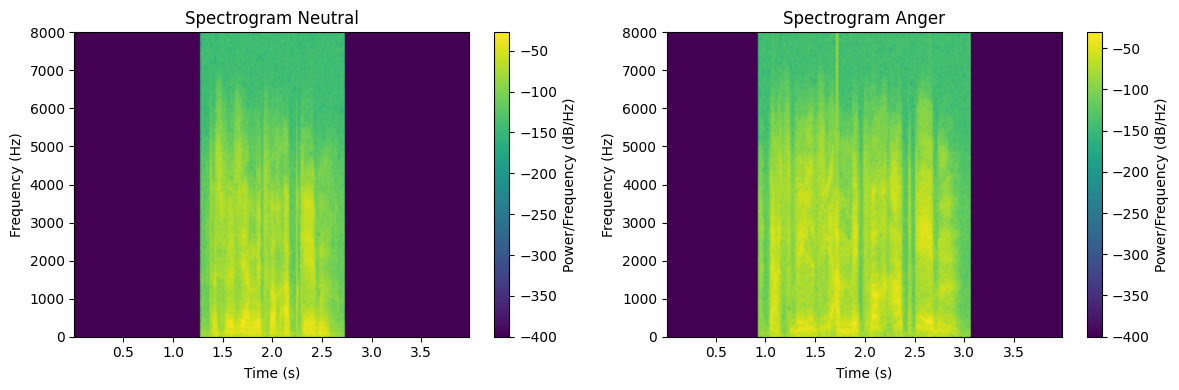

In [18]:
# spectrogram visualization
epsilon = 1e-40
f_n, t_n, Sxx_n = spectrogram(waveform_n, fs=sampling_rate_n)

f_w, t_w, Sxx_w = spectrogram(waveform_w, fs=sampling_rate_w)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

pcm1 = ax1.pcolormesh(t_n, f_n, 10 * np.log10(Sxx_n + epsilon), shading='gouraud')
fig.colorbar(pcm1, ax=ax1, label='Power/Frequency (dB/Hz)')
ax1.set_title("Spectrogram Neutral")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Frequency (Hz)")

pcm2 = ax2.pcolormesh(t_w, f_w, 10 * np.log10(Sxx_w + epsilon), shading='gouraud')
fig.colorbar(pcm2, ax=ax2, label='Power/Frequency (dB/Hz)')
ax2.set_title("Spectrogram Anger")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Frequency (Hz)")

plt.tight_layout()
plt.savefig("gdrive/MyDrive/FDL_Project_Genuardi_Noè/Images/NWspectrograms.png")
plt.show()

### MFCCs (Mel Frequancy Cepstral Coefficients)

In [19]:
# MFCC extraction functions
def extract_mfcc(y, sr):

    N_FFT = 1024
    HOP_LENGTH = 512
    N_MFCC = 13

    mfcc = librosa.feature.mfcc(
        y=y, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH
    )
    return mfcc.T

def process_all_files(input_root, output_root):
    os.makedirs(output_root, exist_ok=True)

    for file_name in tqdm(os.listdir(input_root), desc='MFCC Extraction'):
        if not file_name.endswith('.wav'):
            continue

        SAMPLE_RATE = 16000

        file_path = os.path.join(input_root, file_name)
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        mfcc = extract_mfcc(y, sr)

        out_name = file_name.replace('.wav', '.npy')
        out_path = os.path.join(output_root, out_name)
        np.save(out_path, mfcc)

In [20]:
# MFCC extraction
process_all_files(input_root = 'preprocessed_data', output_root = 'mfcc_data')

MFCC Extraction: 100%|██████████| 535/535 [00:04<00:00, 126.52it/s]


#### Data Exploration MFCC

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


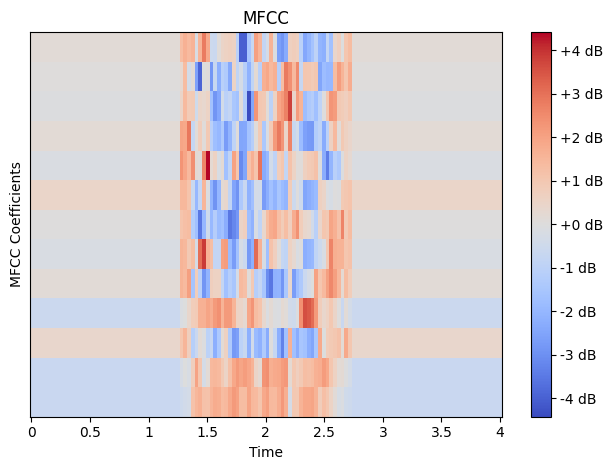

MFCC is of type <class 'numpy.ndarray'> with shape (13, 126)


In [21]:
# MFCC visualization
mfcc = librosa.feature.mfcc(y=waveform_n, sr=16000, n_mfcc=13, n_fft=1024, hop_length=512)

mfcc = scale(mfcc, axis=1)
librosa.display.specshow(mfcc, sr=16000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.tight_layout()
plt.savefig('gdrive/MyDrive/FDL_Project_Genuardi_Noè/Images/mfcc.png')
plt.show()

print (f'MFCC is of type {type(mfcc)} with shape {mfcc.shape}')

## 3. Models


### Initialization (common to all models)

In [22]:
# inizialising the number of classes
num_classes = len(label_map)

In [23]:
# giving a name to the top 3 metric of keras
top_3_metric = keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top_3_accuracy")

#### Functions for dataset creation

In [24]:
# defining the functions for path and labels loading and dataset creation
def load_npy_paths_and_labels(base_dir, split, label_map):
    file_paths = []
    labels = []

    split_dir = os.path.join(base_dir, split)
    for emotion, label in label_map.items():
        emotion_dir = os.path.join(split_dir, emotion)
        if not os.path.exists(emotion_dir):
            continue
        for file in os.listdir(emotion_dir):
            if file.endswith('.npy'):
                file_paths.append(os.path.join(emotion_dir, file))
                labels.append(label)

    return file_paths, labels


def load_npy(path):
  data = tf.numpy_function(np.load, [path], tf.float32)
  data.set_shape([None, 13])
  return data


def create_dataset(file_paths, labels, batch_size=32, shuffle=True):
    if len(file_paths) == 0:
        return tf.data.Dataset.from_tensor_slices(([], [])).batch(batch_size)

    path_ds = tf.data.Dataset.from_tensor_slices(file_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)

    data_ds = path_ds.map(load_npy, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = tf.data.Dataset.zip((data_ds, label_ds))

    if shuffle and len(file_paths) > 0:
        dataset = dataset.shuffle(buffer_size=len(file_paths))

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

In [25]:
# defining a function that reduces the MFCC dimensionality for MLP
def compute_batch_mfcc_mean_std(batch, labels):
    mean = tf.reduce_mean(batch, axis=1)
    std = tf.math.reduce_std(batch, axis=1)
    features = tf.concat([mean, std], axis=1)
    return features, labels

#### Data Augmentation and LOSO Split

In [26]:
# defining functions to add noise and to shift the audio
def add_noise(data, noise_factor):
    noise = np.random.randn(*data.shape)
    augmented_data = data + noise_factor * noise
    return augmented_data

def shift_time(data, sampling_rate, shift_max=0.2, shift_direction='both'):
    augmented_data = []

    for sample in data:

        shift = np.random.randint(int(sample.shape[0] * shift_max))


        if shift_direction == 'right':
            shift = -shift
        elif shift_direction == 'both':
            direction = np.random.randint(0, 2)
            if direction == 1:
                shift = -shift

        rolled = np.roll(sample, shift, axis=0)
        if shift > 0:
            rolled[:shift] = 0
        elif shift < 0:
            rolled[shift:] = 0

        augmented_data.append(rolled)

    return np.array(augmented_data)

In [27]:
# defining the LOSO splitting function
def create_loso_split(leave_out_speaker, speaker_dict, emotion_map, src_dir, dest_dir):
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)

    for split in ['train', 'val']:
        for emotion in set(emotion_map.values()):
            os.makedirs(os.path.join(dest_dir, split, emotion), exist_ok=True)

    for speaker_id, files in speaker_dict.items():
        for f in files:
            if not f.endswith('.wav'):
                continue
            f = f"{f[:7]}.npy"
            emotion_code = f[5]
            emotion = emotion_map.get(emotion_code)
            if not emotion:
                continue

            src = os.path.join(src_dir, f)

            if speaker_id == leave_out_speaker:
                split = 'val'
            else:
                split = 'train'

            dst = os.path.join(dest_dir, split, emotion, f)
            shutil.copy2(src, dst)

In [28]:
# LOSO splitting and data augmentation
set_seed(6461)
loso_datatsets = {}
for speaker_id in speaker_dict.keys():
    loso_datatsets[speaker_id] = {}
    print(f"\n=== LOSO: Leaving out speaker {speaker_id} ===")

    loso_dir = f"mfcc_loso_speaker_{speaker_id}"
    create_loso_split(speaker_id, speaker_dict, emotion_map, 'mfcc_data', loso_dir)

    # define sets for each iteration
    train_paths, train_labels = load_npy_paths_and_labels(loso_dir, 'train', label_map)
    val_paths, val_labels = load_npy_paths_and_labels(loso_dir, 'val', label_map)

    train_dataset = create_dataset(train_paths, train_labels, 1, True)
    val_dataset = create_dataset(val_paths, val_labels, 32, False)

    # augment train dataset
    count = 0
    for element in train_dataset.take(600):
      count += element[0].shape[0]
    print(f"Number of elements in training set before augmentation: {count}")

    emo_counts = {}

    for element in train_dataset.take(count):
      original_audio = element[0].numpy()
      label = element[1].numpy()

      # Convert tensor to numpy array before using as dictionary key
      label_key = label[0]
      if label_key not in emo_counts:
        emo_counts[label_key] = 1
      else:
        emo_counts[label_key] += 1
      if emo_counts[label_key] < 150:
        augmented_data_1 = add_noise(original_audio, 0.005)
        augmented_data_2 = shift_time(original_audio, 16000, shift_max=0.2, shift_direction='both')
        aug1 = tf.convert_to_tensor(augmented_data_1, dtype=tf.float32)
        aug2 = tf.convert_to_tensor(augmented_data_2, dtype=tf.float32)
        label = tf.convert_to_tensor(label)
        element1 = (aug1, label)
        element2 = (aug2, label)
        augmented_dataset = tf.data.Dataset.from_tensor_slices(([aug1, aug2], [label, label]))
        train_dataset = train_dataset.concatenate(augmented_dataset)
        emo_counts[label_key] += 2

    train_dataset = train_dataset.unbatch()
    train_dataset = train_dataset.shuffle(buffer_size=1500)
    train_dataset = train_dataset.batch(32)

    count = 0
    for element in train_dataset.take(200):
      count += element[0].shape[0]
    print(f"Number of elements in training set after augmentation: {count}")

    loso_datatsets[speaker_id]['training'] = train_dataset
    loso_datatsets[speaker_id]['validation'] = val_dataset


=== LOSO: Leaving out speaker 03 ===
Number of elements in training set before augmentation: 486
Number of elements in training set after augmentation: 1176

=== LOSO: Leaving out speaker 11 ===
Number of elements in training set before augmentation: 480
Number of elements in training set after augmentation: 1168

=== LOSO: Leaving out speaker 08 ===
Number of elements in training set before augmentation: 477
Number of elements in training set after augmentation: 1169

=== LOSO: Leaving out speaker 14 ===
Number of elements in training set before augmentation: 466
Number of elements in training set after augmentation: 1142

=== LOSO: Leaving out speaker 13 ===
Number of elements in training set before augmentation: 474
Number of elements in training set after augmentation: 1150

=== LOSO: Leaving out speaker 12 ===
Number of elements in training set before augmentation: 500
Number of elements in training set after augmentation: 1188

=== LOSO: Leaving out speaker 10 ===
Number of elem

#### Functions for plots

In [29]:
# defining a function to plot the ROC and the AUC
def plot_roc_curve(y_true, y_score, n_classes, classes=None,save_name=None):

    if len(y_true.shape) == 1 or y_true.shape[1] == 1:
        y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
    else:
        y_true_bin = y_true

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['crimson', 'slategrey', 'forestgreen', 'darkviolet', 'darkorange', 'navy', 'saddlebrown'])

    plt.figure(figsize=(10, 8))

    for i, color in zip(range(n_classes), colors):
        if classes is not None:
            lab = f'{classes[i]} (AUC = {roc_auc[i]:.3f})'
        else:
            lab = f'Class {i} (AUC = {roc_auc[i]:.3f})'
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=lab)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve for each class')
    plt.legend(loc="lower right")
    plt.grid(True)

    if save_name is not None:
        plt.savefig(f"gdrive/MyDrive/FDL_Project_Genuardi_Noè/Images/{save_name}.png")

    plt.show()

In [30]:
# defining a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues, save_name=None):

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    if save_name is not None:
        plt.savefig(f"gdrive/MyDrive/FDL_Project_Genuardi_Noè/Images/{save_name}.png", bbox_inches='tight')

    plt.show()

### 3.1 MLP

In [32]:
evaluations_MLP = {}
final_accuracy_MLP = {}
final_top_3_accuracy_MLP = {}
y_true_all_MLP = {}
y_score_all_MLP = {}
y_pred_all_MLP = {}

# implement LOSO cycle
for speaker_id in speaker_dict.keys():
    print(f"\n=== LOSO: Leaving out speaker {speaker_id} ===")

    train_dataset = loso_datatsets[speaker_id]['training']
    val_dataset = loso_datatsets[speaker_id]['validation']

    train_dataset = train_dataset.map(compute_batch_mfcc_mean_std)
    val_dataset = val_dataset.map(compute_batch_mfcc_mean_std)

    set_seed(6461)

    # define net
    inputs = keras.layers.Input(shape=(26,))

    x = keras.layers.Dense(256, activation="relu")(inputs)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dense(128, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dense(64, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dense(32, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)

    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

    net = keras.Model(inputs, outputs)

    net.compile(loss=keras.losses.sparse_categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy', top_3_metric])

    net.load_weights(f'gdrive/MyDrive/FDL_Project_Genuardi_Noè/ModelsWeights/MLP/MLP_weights_speaker_{speaker_id}.weights.h5')

    evaluation = net.evaluate(val_dataset, verbose=False)

    evaluations_MLP[speaker_id] = evaluation

    final_accuracy_MLP[speaker_id] = evaluation[1]
    final_top_3_accuracy_MLP[speaker_id] = evaluation[2]
    print(f"Final accuracy: {final_accuracy_MLP[speaker_id]}")
    print(f"Final top 3 accuracy: {final_top_3_accuracy_MLP[speaker_id]}")

    # for the plot
    y_true_all = []
    for _, labels in val_dataset:
      y_true_all.extend(labels.numpy())
    y_true_all_MLP[speaker_id] = np.array(y_true_all)
    y_score_all_MLP[speaker_id] = net.predict(val_dataset, verbose=False)
    y_pred_all_MLP[speaker_id] = np.argmax(y_score_all_MLP[speaker_id], axis=1)


=== LOSO: Leaving out speaker 03 ===


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Final accuracy: 0.5102040767669678
Final top 3 accuracy: 0.918367326259613

=== LOSO: Leaving out speaker 11 ===
Final accuracy: 0.7090908885002136
Final top 3 accuracy: 0.932692289352417

=== LOSO: Leaving out speaker 08 ===
Final accuracy: 0.6551724076271057
Final top 3 accuracy: 0.9259259104728699



=== LOSO: Leaving out speaker 14 ===
Final accuracy: 0.7101449370384216
Final top 3 accuracy: 0.9437229633331299

=== LOSO: Leaving out speaker 13 ===


Final accuracy: 0.688524603843689
Final top 3 accuracy: 0.9417808055877686

=== LOSO: Leaving out speaker 12 ===


Final accuracy: 0.7714285850524902
Final top 3 accuracy: 0.9388379454612732

=== LOSO: Leaving out speaker 10 ===
Final accuracy: 0.5789473652839661
Final top 3 accuracy: 0.931506872177124

=== LOSO: Leaving out speaker 15 ===
Final accuracy: 0.625
Final top 3 accuracy: 0.9216151833534241

=== LOSO: Leaving out speaker 16 ===
Final accuracy: 0.5070422291755676
Final top 3 accuracy: 0.9024389982223511

=== LOSO: Leaving out speaker 09 ===
Final accuracy: 0.6279069781303406
Final top 3 accuracy: 0.9028037190437317


In [33]:
mean_accuracy_MLP = np.mean(list(final_accuracy_MLP.values()))
mean_top_3_accuracy_MLP = np.mean(list(final_top_3_accuracy_MLP.values()))
print(f"Mean accuracy for MLP: {mean_accuracy_MLP}")
print(f"Mean top 3 accuracy for MLP: {mean_top_3_accuracy_MLP}")

Mean accuracy for MLP: 0.6383462071418762
Mean top 3 accuracy for MLP: 0.9259692013263703


In [34]:
# Concatenate true and predicted labels from all speakers
all_y_true = []
all_y_pred = []
all_y_score = []

for speaker_id in speaker_dict.keys():
    all_y_true.extend(y_true_all_MLP[speaker_id])
    all_y_pred.extend(y_pred_all_MLP[speaker_id])
    all_y_score.extend(y_score_all_MLP[speaker_id])

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_score = np.array(all_y_score)

In [35]:
print(classification_report(all_y_true, all_y_pred, target_names=list(emotion_map.values())))

              precision    recall  f1-score   support

       anger       0.81      0.83      0.82       127
     boredom       0.63      0.27      0.38        81
     disgust       0.50      0.70      0.58        46
        fear       0.75      0.48      0.58        69
   happiness       0.49      0.56      0.52        71
     sadness       0.75      0.74      0.75        62
     neutral       0.52      0.77      0.62        79

    accuracy                           0.64       535
   macro avg       0.64      0.62      0.61       535
weighted avg       0.66      0.64      0.63       535



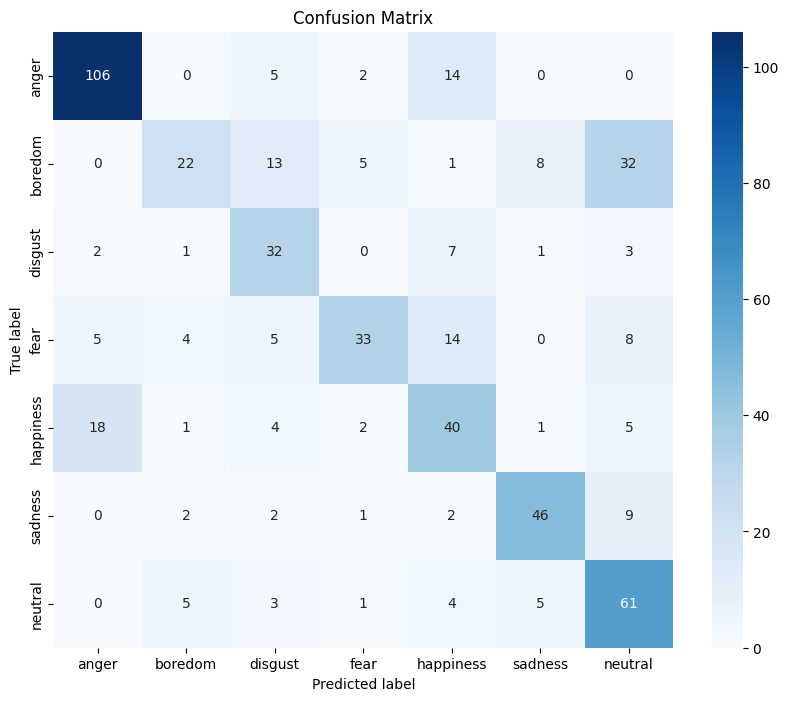

In [36]:
plot_confusion_matrix(all_y_true, all_y_pred, list(emotion_map.values()))

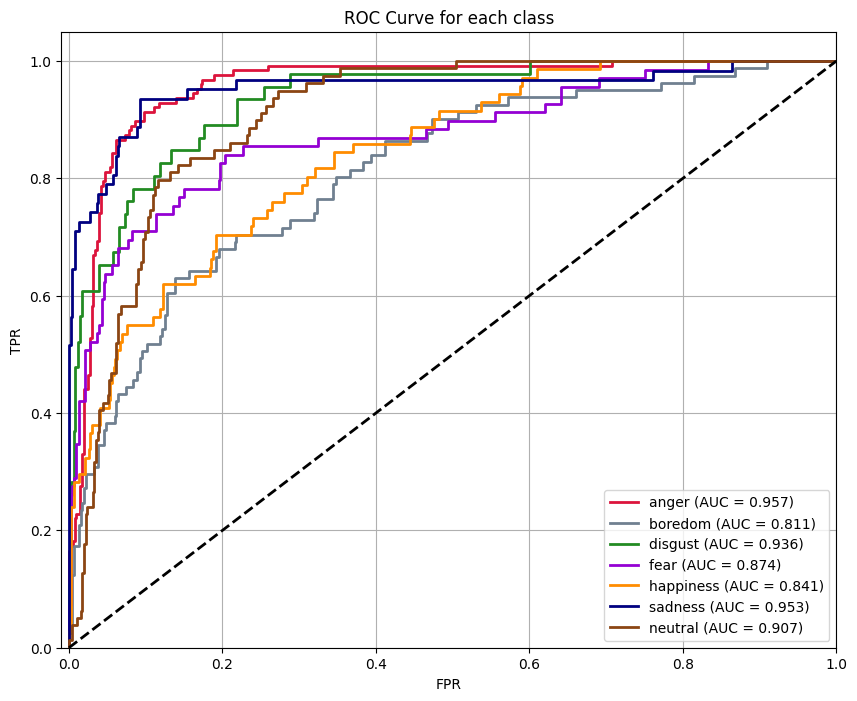

In [37]:
plot_roc_curve(all_y_true, all_y_score, num_classes, list(emotion_map.values()))

### 3.2 CNN

#### CNN 1D

In [38]:
evaluations_CNN1D = {}
final_accuracy_CNN1D = {}
final_top_3_accuracy_CNN1D = {}
y_true_all_CNN1D = {}
y_score_all_CNN1D = {}
y_pred_all_CNN1D = {}

# implement LOSO cycle
for speaker_id in speaker_dict.keys():
    print(f"\n=== LOSO: Leaving out speaker {speaker_id} ===")

    train_dataset = loso_datatsets[speaker_id]['training']
    val_dataset = loso_datatsets[speaker_id]['validation']

    set_seed(6461)

    # define net
    inputs = keras.layers.Input(shape=(126, 13))

    x = keras.layers.Conv1D(64, 3, strides=1, padding="same", activation='relu')(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling1D(pool_size=2)(x)

    x = keras.layers.Conv1D(128, 3, strides=1, padding="same", activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-4, l2=0.001))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling1D(pool_size=2)(x)
    x = keras.layers.Dropout(0.2)(x)

    x = keras.layers.Conv1D(256, 3, strides=1, padding="same", activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-4, l2=0.001))(x)
    x = keras.layers.GlobalAveragePooling1D()(x)
    x = keras.layers.Dropout(0.2)(x)

    x = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-4, l2=0.001))(x)
    x = keras.layers.Dropout(0.3)(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

    net = keras.Model(inputs, outputs)

    # compile
    net.compile(loss=keras.losses.sparse_categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy', top_3_metric])

    net.load_weights(f'gdrive/MyDrive/FDL_Project_Genuardi_Noè/ModelsWeights/CNN1D/CNN1D_weights_speaker_{speaker_id}.weights.h5')

    evaluation = net.evaluate(val_dataset, verbose=False)

    evaluations_CNN1D[speaker_id] = evaluation

    final_accuracy_CNN1D[speaker_id] = evaluation[1]
    final_top_3_accuracy_CNN1D[speaker_id] = evaluation[2]
    print(f"Final accuracy: {final_accuracy_CNN1D[speaker_id]}")
    print(f"Final top 3 accuracy: {final_top_3_accuracy_CNN1D[speaker_id]}")

    # for the plot
    y_true_all = []
    for _, labels in val_dataset:
      y_true_all.extend(labels.numpy())
    y_true_all_CNN1D[speaker_id] = np.array(y_true_all)
    y_score_all_CNN1D[speaker_id] = net.predict(val_dataset, verbose=False)
    y_pred_all_CNN1D[speaker_id] = np.argmax(y_score_all_CNN1D[speaker_id], axis=1)


=== LOSO: Leaving out speaker 03 ===


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Final accuracy: 0.7755101919174194
Final top 3 accuracy: 0.909246563911438

=== LOSO: Leaving out speaker 11 ===
Final accuracy: 0.7454545497894287
Final top 3 accuracy: 0.9139280319213867

=== LOSO: Leaving out speaker 08 ===
Final accuracy: 0.6551724076271057
Final top 3 accuracy: 0.9124820828437805

=== LOSO: Leaving out speaker 14 ===
Final accuracy: 0.8260869383811951
Final top 3 accuracy: 0.9190600514411926

=== LOSO: Leaving out speaker 13 ===
Final accuracy: 0.7377049326896667
Final top 3 accuracy: 0.9238210320472717

=== LOSO: Leaving out speaker 12 ===
Final accuracy: 0.7142857313156128
Final top 3 accuracy: 0.9234338998794556

=== LOSO: Leaving out speaker 10 ===
Final accuracy: 0.6578947305679321
Final top 3 accuracy: 0.9255555272102356

=== LOSO: Leaving out speaker 15 ===
Final accuracy: 0.7678571343421936
Final top 3 accuracy: 0.9288703203201294

=== LOSO: Leaving out speaker 16 ===
Final accuracy: 0.577464759349823
Final top 3 accuracy: 0.9259980320930481

=== LOSO: Lea

In [39]:
mean_accuracy_CNN1D = np.mean(list(final_accuracy_CNN1D.values()))
mean_top_3_accuracy_CNN1D = np.mean(list(final_top_3_accuracy_CNN1D.values()))
print(f"Mean accuracy for CNN1D: {mean_accuracy_CNN1D}")
print(f"Mean top 3 accuracy for CNN1D: {mean_top_3_accuracy_CNN1D}")

Mean accuracy for CNN1D: 0.7085338354110717
Mean top 3 accuracy for CNN1D: 0.9210432946681977


In [40]:
# Concatenate true and predicted labels from all speakers
all_y_true = []
all_y_pred = []
all_y_score = []

for speaker_id in speaker_dict.keys():
    all_y_true.extend(y_true_all_CNN1D[speaker_id])
    all_y_pred.extend(y_pred_all_CNN1D[speaker_id])
    all_y_score.extend(y_score_all_CNN1D[speaker_id])

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_score = np.array(all_y_score)

In [41]:
print(classification_report(all_y_true, all_y_pred, target_names=list(emotion_map.values())))

              precision    recall  f1-score   support

       anger       0.82      0.86      0.84       127
     boredom       0.67      0.63      0.65        81
     disgust       0.88      0.61      0.72        46
        fear       0.63      0.67      0.65        69
   happiness       0.53      0.58      0.55        71
     sadness       0.75      0.79      0.77        62
     neutral       0.72      0.71      0.71        79

    accuracy                           0.71       535
   macro avg       0.71      0.69      0.70       535
weighted avg       0.72      0.71      0.71       535



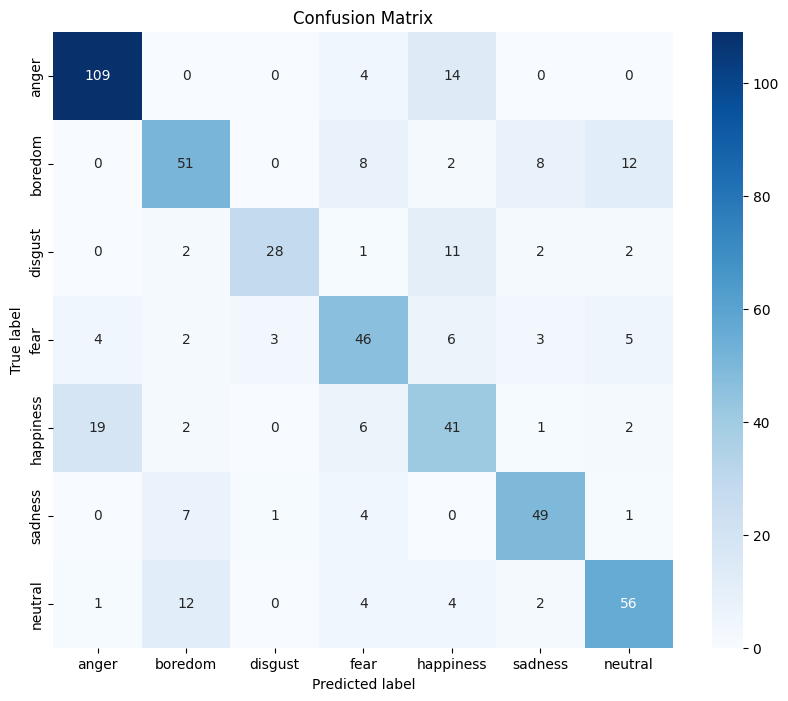

In [42]:
plot_confusion_matrix(all_y_true, all_y_pred, list(emotion_map.values()))

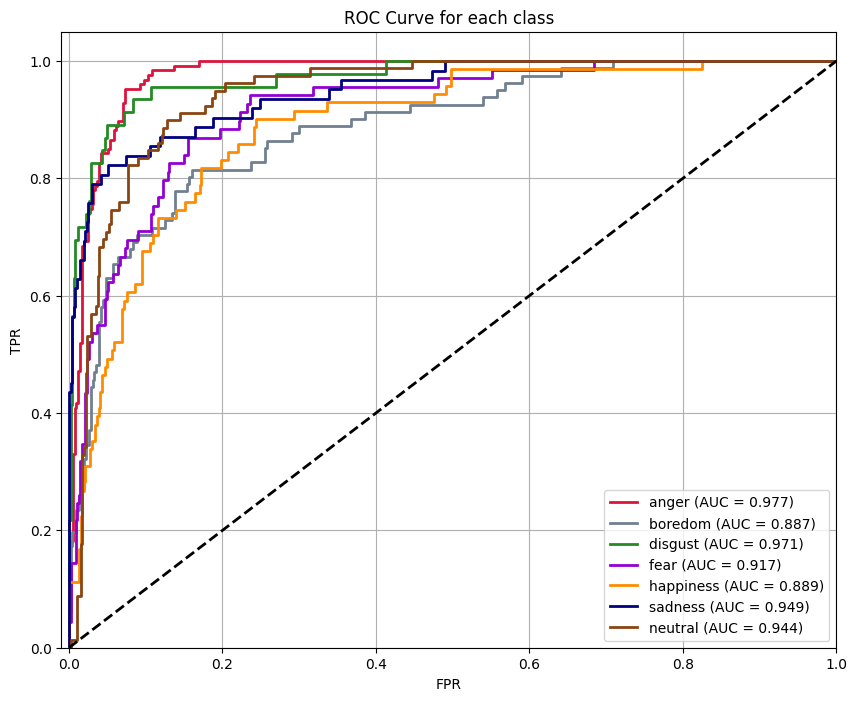

In [43]:
plot_roc_curve(all_y_true, all_y_score, num_classes, list(emotion_map.values()))

#### CNN 2D

In [44]:
evaluations_CNN2D = {}
final_accuracy_CNN2D = {}
final_top_3_accuracy_CNN2D = {}
y_true_all_CNN2D = {}
y_score_all_CNN2D = {}
y_pred_all_CNN2D = {}

# implement LOSO cycle
for speaker_id in speaker_dict.keys():
    print(f"\n=== LOSO: Leaving out speaker {speaker_id} ===")

    train_dataset = loso_datatsets[speaker_id]['training']
    val_dataset = loso_datatsets[speaker_id]['validation']

    set_seed(6461)

    # define net
    inputs = keras.layers.Input(shape=(126, 13, 1))

    x = keras.layers.Conv2D(16, 5, padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.MaxPooling2D(2, padding="same")(x)

    x = keras.layers.Conv2D(32, 5, padding="same")(x)
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.MaxPooling2D(2, padding="same")(x)

    x = keras.layers.Conv2D(64, 5, padding="same")(x)
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.MaxPooling2D(2, padding="same")(x)

    x = keras.layers.Conv2D(128, 5, padding="same")(x)
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.MaxPooling2D(2, padding="same")(x)

    x = keras.layers.GlobalMaxPooling2D()(x)

    x = keras.layers.Dense(64, activation="relu")(x)


    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

    net = keras.Model(inputs, outputs)


    # compile
    net.compile(loss=keras.losses.sparse_categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy', top_3_metric])

    net.load_weights(f'gdrive/MyDrive/FDL_Project_Genuardi_Noè/ModelsWeights/CNN2D/CNN2D_weights_speaker_{speaker_id}.weights.h5')

    evaluation = net.evaluate(val_dataset, verbose=False)

    evaluations_CNN2D[speaker_id] = evaluation

    final_accuracy_CNN2D[speaker_id] = evaluation[1]
    final_top_3_accuracy_CNN2D[speaker_id] = evaluation[2]
    print(f"Final accuracy: {final_accuracy_CNN2D[speaker_id]}")
    print(f"Final top 3 accuracy: {final_top_3_accuracy_CNN2D[speaker_id]}")

    # for the plot

    y_true_all = []
    for _, labels in val_dataset:
      y_true_all.extend(labels.numpy())
    y_true_all_CNN2D[speaker_id] = np.array(y_true_all)
    y_score_all_CNN2D[speaker_id] = net.predict(val_dataset, verbose=False)
    y_pred_all_CNN2D[speaker_id] = np.argmax(y_score_all_CNN2D[speaker_id], axis=1)


=== LOSO: Leaving out speaker 03 ===


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Final accuracy: 0.795918345451355
Final top 3 accuracy: 0.930294930934906

=== LOSO: Leaving out speaker 11 ===
Final accuracy: 0.6909090876579285
Final top 3 accuracy: 0.9310051202774048

=== LOSO: Leaving out speaker 08 ===
Final accuracy: 0.7758620977401733
Final top 3 accuracy: 0.9326298832893372

=== LOSO: Leaving out speaker 14 ===
Final accuracy: 0.8115941882133484
Final top 3 accuracy: 0.9346656203269958

=== LOSO: Leaving out speaker 13 ===
Final accuracy: 0.7213114500045776
Final top 3 accuracy: 0.9361233711242676

=== LOSO: Leaving out speaker 12 ===
Final accuracy: 0.7142857313156128
Final top 3 accuracy: 0.9348604083061218

=== LOSO: Leaving out speaker 10 ===
Final accuracy: 0.5789473652839661
Final top 3 accuracy: 0.9351916313171387

=== LOSO: Leaving out speaker 15 ===
Final accuracy: 0.7678571343421936
Final top 3 accuracy: 0.9349430203437805

=== LOSO: Leaving out speaker 16 ===
Final accuracy: 0.5633803009986877
Final top 3 accuracy: 0.9359794855117798

=== LOSO: Lea

In [45]:
mean_accuracy_CNN2D = np.mean(list(final_accuracy_CNN2D.values()))
mean_top_3_accuracy_CNN2D = np.mean(list(final_top_3_accuracy_CNN2D.values()))
print(f"Mean accuracy for CNN2D: {mean_accuracy_CNN2D}")
print(f"Mean top 3 accuracy for CNN2D: {mean_top_3_accuracy_CNN2D}")

Mean accuracy for CNN2D: 0.7117740094661713
Mean top 3 accuracy for CNN2D: 0.9341518998146057


In [46]:
# Concatenate true and predicted labels from all speakers
all_y_true = []
all_y_pred = []
all_y_score = []

for speaker_id in speaker_dict.keys():
    all_y_true.extend(y_true_all_CNN2D[speaker_id])
    all_y_pred.extend(y_pred_all_CNN2D[speaker_id])
    all_y_score.extend(y_score_all_CNN2D[speaker_id])

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_score = np.array(all_y_score)

In [47]:
print(classification_report(all_y_true, all_y_pred, target_names=list(emotion_map.values())))

              precision    recall  f1-score   support

       anger       0.77      0.92      0.84       127
     boredom       0.83      0.56      0.67        81
     disgust       0.63      0.57      0.60        46
        fear       0.60      0.61      0.60        69
   happiness       0.60      0.44      0.50        71
     sadness       0.90      0.90      0.90        62
     neutral       0.62      0.82      0.71        79

    accuracy                           0.71       535
   macro avg       0.71      0.69      0.69       535
weighted avg       0.72      0.71      0.71       535



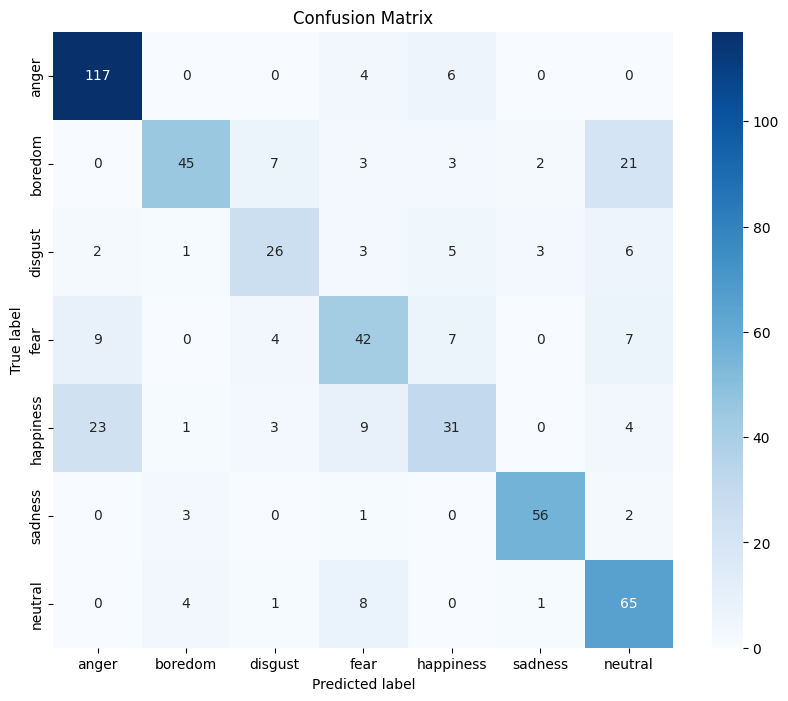

In [48]:
plot_confusion_matrix(all_y_true, all_y_pred, list(emotion_map.values()))

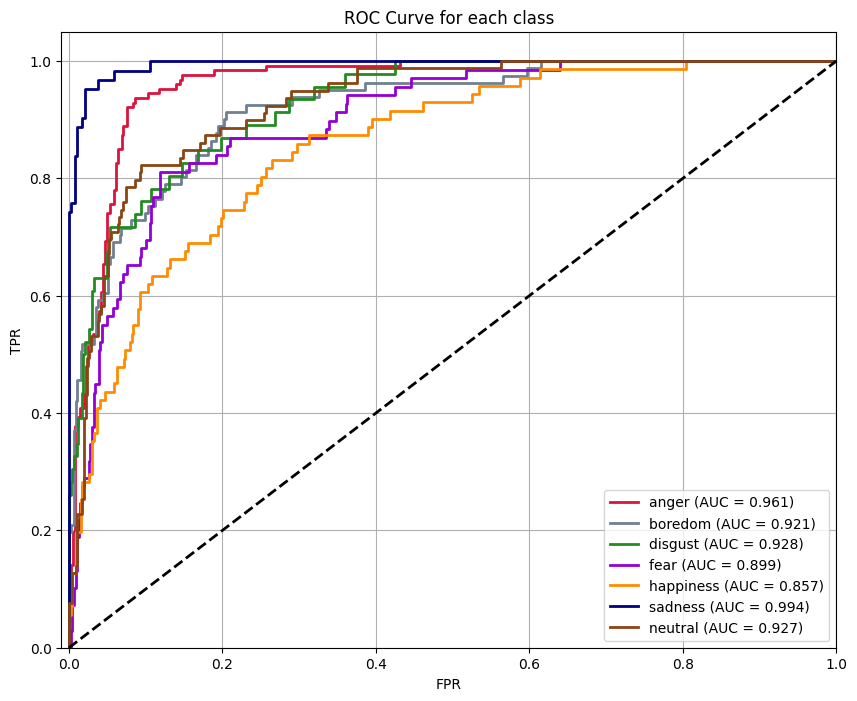

In [49]:
plot_roc_curve(all_y_true, all_y_score, num_classes, list(emotion_map.values()))

### 3.3 RNN - LSTM

In [50]:
evaluations_LSTM = {}
final_accuracy_LSTM = {}
final_top_3_accuracy_LSTM = {}
y_true_all_LSTM = {}
y_score_all_LSTM = {}
y_pred_all_LSTM = {}

# implement LOSO cycle
for speaker_id in speaker_dict.keys():
    print(f"\n=== LOSO: Leaving out speaker {speaker_id} ===")

    train_dataset = loso_datatsets[speaker_id]['training']
    val_dataset = loso_datatsets[speaker_id]['validation']

    set_seed(6461)

    # define net
    inputs = keras.layers.Input(shape=(126, 13))

    x = keras.layers.LSTM(128, return_sequences=True)(inputs)

    x = keras.layers.LSTM(64)(x)

    x = keras.layers.Dense(64, activation='relu')(x)

    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

    net = keras.Model(inputs=inputs, outputs=outputs)


    # compile
    net.compile(loss=keras.losses.sparse_categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy', top_3_metric])

    net.load_weights(f'gdrive/MyDrive/FDL_Project_Genuardi_Noè/ModelsWeights/LSTM/LSTM_weights_speaker_{speaker_id}.weights.h5')

    evaluation = net.evaluate(val_dataset, verbose=False)

    evaluations_LSTM[speaker_id] = evaluation

    final_accuracy_LSTM[speaker_id] = evaluation[1]
    final_top_3_accuracy_LSTM[speaker_id] = evaluation[2]
    print(f"Final accuracy: {final_accuracy_LSTM[speaker_id]}")
    print(f"Final top 3 accuracy: {final_top_3_accuracy_LSTM[speaker_id]}")

    # for the plot

    y_true_all = []
    for _, labels in val_dataset:
      y_true_all.extend(labels.numpy())
    y_true_all_LSTM[speaker_id] = np.array(y_true_all)
    y_score_all_LSTM[speaker_id] = net.predict(val_dataset, verbose=False)
    y_pred_all_LSTM[speaker_id] = np.argmax(y_score_all_LSTM[speaker_id], axis=1)


=== LOSO: Leaving out speaker 03 ===


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Final accuracy: 0.7551020383834839
Final top 3 accuracy: 0.9365175366401672

=== LOSO: Leaving out speaker 11 ===
Final accuracy: 0.6727272868156433
Final top 3 accuracy: 0.9373902678489685

=== LOSO: Leaving out speaker 08 ===
Final accuracy: 0.7068965435028076
Final top 3 accuracy: 0.9383135437965393

=== LOSO: Leaving out speaker 14 ===
Final accuracy: 0.782608687877655
Final top 3 accuracy: 0.9395424723625183

=== LOSO: Leaving out speaker 13 ===
Final accuracy: 0.7049180269241333
Final top 3 accuracy: 0.9388508200645447

=== LOSO: Leaving out speaker 12 ===
Final accuracy: 0.7428571581840515
Final top 3 accuracy: 0.9373705983161926

=== LOSO: Leaving out speaker 10 ===
Final accuracy: 0.7631579041481018
Final top 3 accuracy: 0.9385786652565002

=== LOSO: Leaving out speaker 15 ===
Final accuracy: 0.6785714030265808
Final top 3 accuracy: 0.9387956857681274

=== LOSO: Leaving out speaker 16 ===
Final accuracy: 0.5492957830429077
Final top 3 accuracy: 0.9380066990852356

=== LOSO: Le

In [51]:
mean_accuracy_LSTM = np.mean(list(final_accuracy_LSTM.values()))
mean_top_3_accuracy_LSTM = np.mean(list(final_top_3_accuracy_LSTM.values()))
print(f"Mean accuracy for LSTM: {mean_accuracy_LSTM}")
print(f"Mean top 3 accuracy for LSTM: {mean_top_3_accuracy_LSTM}")

Mean accuracy for LSTM: 0.6937530159950256
Mean top 3 accuracy for LSTM: 0.9381684064865112


In [52]:
# Concatenate true and predicted labels from all speakers
all_y_true = []
all_y_pred = []
all_y_score = []

for speaker_id in speaker_dict.keys():
    all_y_true.extend(y_true_all_LSTM[speaker_id])
    all_y_pred.extend(y_pred_all_LSTM[speaker_id])
    all_y_score.extend(y_score_all_LSTM[speaker_id])

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_score = np.array(all_y_score)

In [53]:
print(classification_report(all_y_true, all_y_pred, target_names=list(emotion_map.values())))

              precision    recall  f1-score   support

       anger       0.81      0.83      0.82       127
     boredom       0.69      0.63      0.66        81
     disgust       0.62      0.65      0.64        46
        fear       0.62      0.55      0.58        69
   happiness       0.57      0.59      0.58        71
     sadness       0.85      0.82      0.84        62
     neutral       0.59      0.65      0.61        79

    accuracy                           0.69       535
   macro avg       0.68      0.68      0.68       535
weighted avg       0.69      0.69      0.69       535



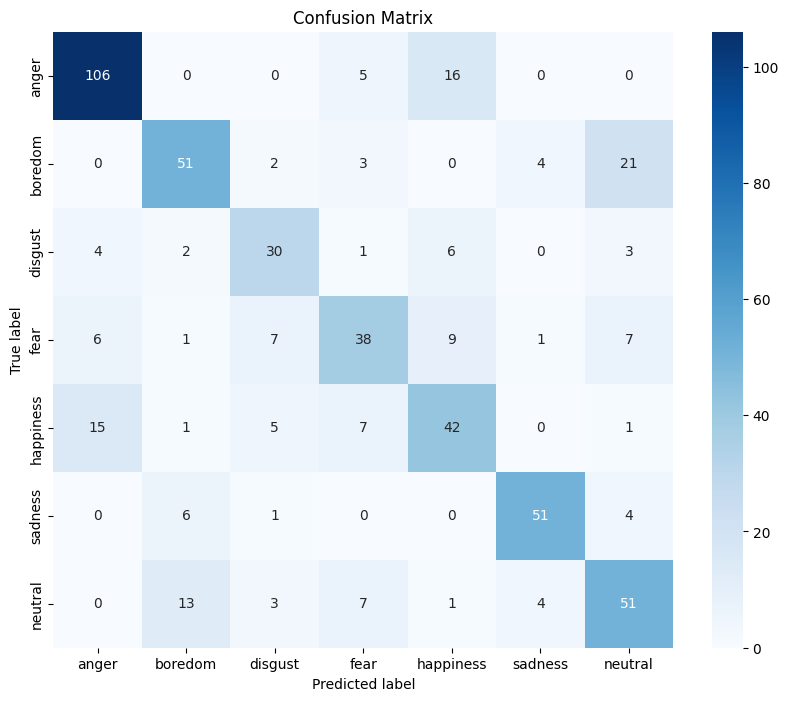

In [54]:
plot_confusion_matrix(all_y_true, all_y_pred, list(emotion_map.values()))

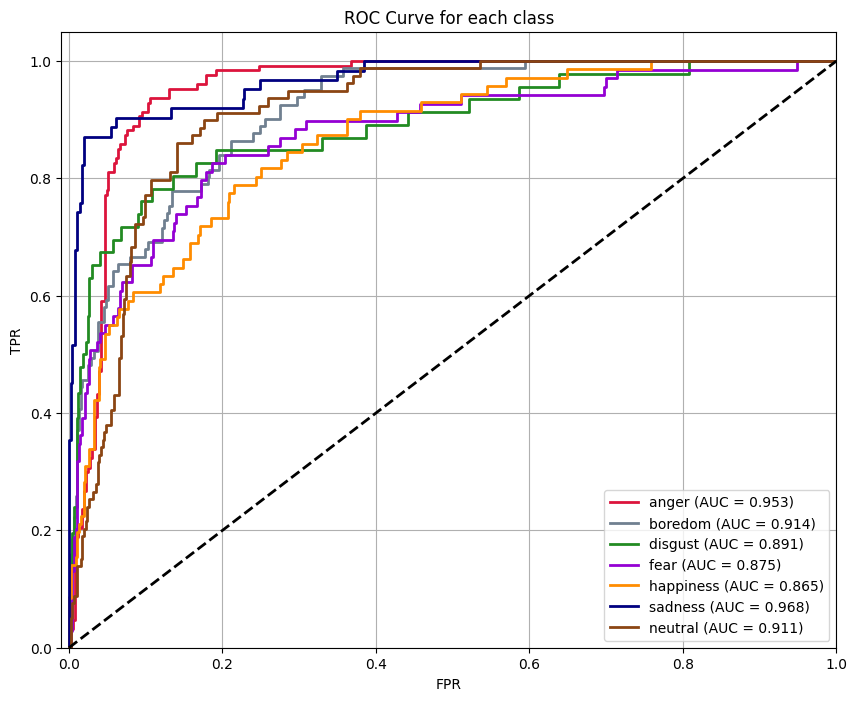

In [55]:
plot_roc_curve(all_y_true, all_y_score, num_classes, list(emotion_map.values()))

### 3.4 CNN + RNN

#### CNN 1D + LSTM

In [56]:
evaluations_1DLSTM = {}
final_accuracy_1DLSTM = {}
final_top_3_accuracy_1DLSTM = {}
y_true_all_1DLSTM = {}
y_score_all_1DLSTM = {}
y_pred_all_1DLSTM = {}

# implement LOSO cycle
for speaker_id in speaker_dict.keys():
    print(f"\n=== LOSO: Leaving out speaker {speaker_id} ===")

    train_dataset = loso_datatsets[speaker_id]['training']
    val_dataset = loso_datatsets[speaker_id]['validation']

    set_seed(6461)

    # define net
    inputs = keras.layers.Input(shape=(126, 13))

    # CNN 1D
    x = keras.layers.Conv1D(16, 3, strides=1, padding="same", activation='relu')(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling1D(pool_size=2)(x)

    x = keras.layers.Conv1D(32, 3, strides=1, padding="same", activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling1D(pool_size=2)(x)

    x = keras.layers.Conv1D(64, 3, strides=1, padding="same", activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = keras.layers.MaxPooling1D(pool_size=2)(x)

    x = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = keras.layers.Dropout(0.3)(x)

    # LSTM
    x = keras.layers.LSTM(128, return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = keras.layers.Dropout(0.2)(x)

    x = keras.layers.LSTM(64, kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = keras.layers.Dropout(0.2)(x)

    x = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

    net = keras.Model(inputs, outputs)

    # compile
    net.compile(loss=keras.losses.sparse_categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy', top_3_metric])

    net.load_weights(f'gdrive/MyDrive/FDL_Project_Genuardi_Noè/ModelsWeights/1DLSTM/1DLSTM_weights_speaker_{speaker_id}.weights.h5')

    evaluation = net.evaluate(val_dataset, verbose=False)

    evaluations_1DLSTM[speaker_id] = evaluation

    final_accuracy_1DLSTM[speaker_id] = evaluation[1]
    final_top_3_accuracy_1DLSTM[speaker_id] = evaluation[2]
    print(f"Final accuracy: {final_accuracy_1DLSTM[speaker_id]}")
    print(f"Final top 3 accuracy: {final_top_3_accuracy_1DLSTM[speaker_id]}")

    # for the plot

    y_true_all = []
    for _, labels in val_dataset:
      y_true_all.extend(labels.numpy())
    y_true_all_1DLSTM[speaker_id] = np.array(y_true_all)
    y_score_all_1DLSTM[speaker_id] = net.predict(val_dataset, verbose=False)
    y_pred_all_1DLSTM[speaker_id] = np.argmax(y_score_all_1DLSTM[speaker_id], axis=1)


=== LOSO: Leaving out speaker 03 ===


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Final accuracy: 0.6326530575752258
Final top 3 accuracy: 0.9392416477203369

=== LOSO: Leaving out speaker 11 ===
Final accuracy: 0.7454545497894287
Final top 3 accuracy: 0.9402852058410645

=== LOSO: Leaving out speaker 08 ===
Final accuracy: 0.7586206793785095
Final top 3 accuracy: 0.9409209489822388

=== LOSO: Leaving out speaker 14 ===
Final accuracy: 0.7246376872062683
Final top 3 accuracy: 0.9422184824943542

=== LOSO: Leaving out speaker 13 ===
Final accuracy: 0.6557376980781555
Final top 3 accuracy: 0.9428454041481018

=== LOSO: Leaving out speaker 12 ===
Final accuracy: 0.6857143044471741
Final top 3 accuracy: 0.9400081038475037

=== LOSO: Leaving out speaker 10 ===
Final accuracy: 0.7894737124443054
Final top 3 accuracy: 0.9405189752578735

=== LOSO: Leaving out speaker 15 ===
Final accuracy: 0.6785714030265808
Final top 3 accuracy: 0.940257728099823

=== LOSO: Leaving out speaker 16 ===
Final accuracy: 0.5633803009986877
Final top 3 accuracy: 0.9411094188690186

=== LOSO: Le

In [57]:
mean_accuracy_1DLSTM = np.mean(list(final_accuracy_1DLSTM.values()))
mean_top_3_accuracy_1DLSTM = np.mean(list(final_top_3_accuracy_1DLSTM.values()))
print(f"Mean accuracy for CNN1D + LSTM: {mean_accuracy_1DLSTM}")
print(f"Mean top 3 accuracy for CNN1D + LSTM: {mean_top_3_accuracy_1DLSTM}")

Mean accuracy for CNN1D + LSTM: 0.7001685261726379
Mean top 3 accuracy for CNN1D + LSTM: 0.9408340513706207


In [58]:
# Concatenate true and predicted labels from all speakers
all_y_true = []
all_y_pred = []
all_y_score = []

for speaker_id in speaker_dict.keys():
    all_y_true.extend(y_true_all_1DLSTM[speaker_id])
    all_y_pred.extend(y_pred_all_1DLSTM[speaker_id])
    all_y_score.extend(y_score_all_1DLSTM[speaker_id])

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_score = np.array(all_y_score)

In [59]:
print(classification_report(all_y_true, all_y_pred, target_names=list(emotion_map.values())))

              precision    recall  f1-score   support

       anger       0.76      0.91      0.83       127
     boredom       0.68      0.56      0.61        81
     disgust       0.72      0.61      0.66        46
        fear       0.62      0.70      0.65        69
   happiness       0.59      0.49      0.54        71
     sadness       0.78      0.85      0.82        62
     neutral       0.64      0.58      0.61        79

    accuracy                           0.69       535
   macro avg       0.68      0.67      0.67       535
weighted avg       0.69      0.69      0.69       535



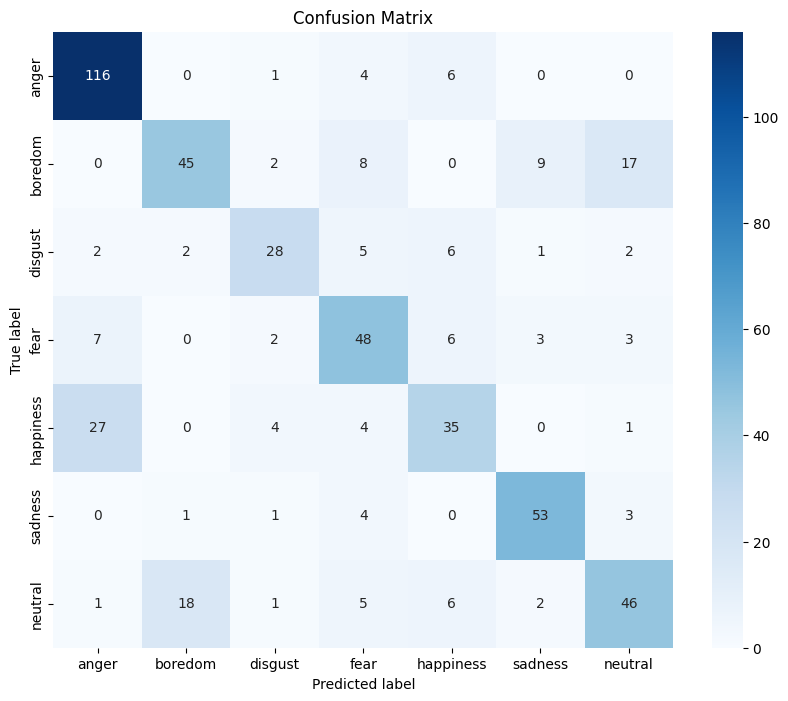

In [60]:
plot_confusion_matrix(all_y_true, all_y_pred, list(emotion_map.values()))

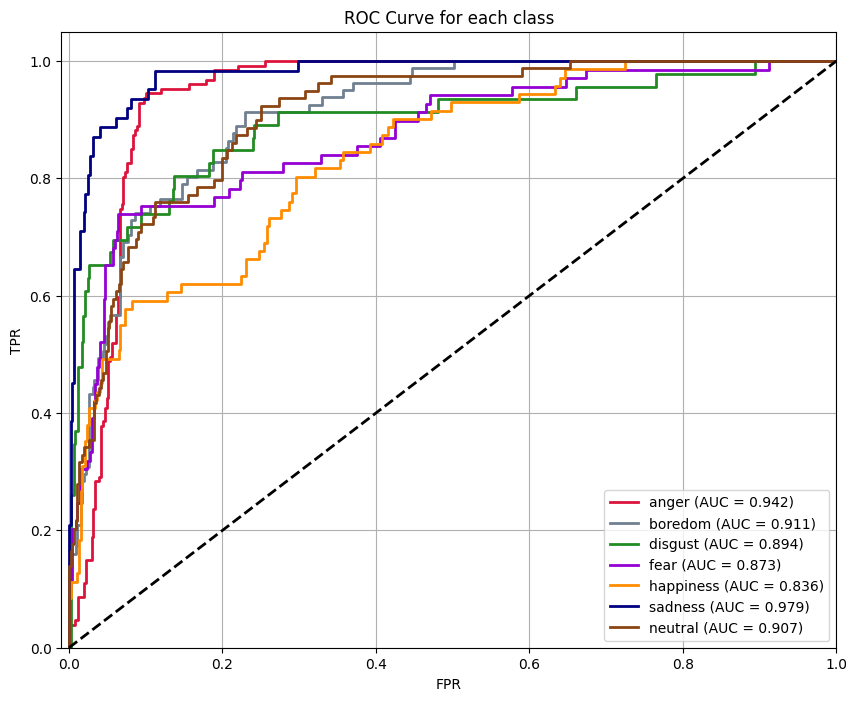

In [61]:
plot_roc_curve(all_y_true, all_y_score, num_classes, list(emotion_map.values()))

#### CNN 2D + LSTM

In [62]:
evaluations_2DLSTM = {}
final_accuracy_2DLSTM = {}
final_top_3_accuracy_2DLSTM = {}
y_true_all_2DLSTM = {}
y_score_all_2DLSTM = {}
y_pred_all_2DLSTM = {}

# implement LOSO cycle
for speaker_id in speaker_dict.keys():
    print(f"\n=== LOSO: Leaving out speaker {speaker_id} ===")

    train_dataset = loso_datatsets[speaker_id]['training']
    val_dataset = loso_datatsets[speaker_id]['validation']

    set_seed(6461)

    # define net
    inputs = keras.Input(shape=(126, 13, 1))

    # CNN 2D
    x = keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x = keras.layers.Reshape((x.shape[1], -1))(x)

    # LSTM
    x = keras.layers.LSTM(128, return_sequences=True)(x)

    x = keras.layers.LSTM(64)(x)

    x = keras.layers.Dense(64, activation='relu')(x)

    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

    net = keras.Model(inputs, outputs)


    # compile
    net.compile(loss=keras.losses.sparse_categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy', top_3_metric])

    net.load_weights(f'gdrive/MyDrive/FDL_Project_Genuardi_Noè/ModelsWeights/2DLSTM/2DLSTM_weights_speaker_{speaker_id}.weights.h5')

    evaluation = net.evaluate(val_dataset, verbose=False)

    evaluations_2DLSTM[speaker_id] = evaluation

    final_accuracy_2DLSTM[speaker_id] = evaluation[1]
    final_top_3_accuracy_2DLSTM[speaker_id] = evaluation[2]
    print(f"Final accuracy: {final_accuracy_2DLSTM[speaker_id]}")
    print(f"Final top 3 accuracy: {final_top_3_accuracy_2DLSTM[speaker_id]}")

    # for the plot

    y_true_all = []
    for _, labels in val_dataset:
      y_true_all.extend(labels.numpy())
    y_true_all_2DLSTM[speaker_id] = np.array(y_true_all)
    y_score_all_2DLSTM[speaker_id] = net.predict(val_dataset, verbose=False)
    y_pred_all_2DLSTM[speaker_id] = np.argmax(y_score_all_2DLSTM[speaker_id], axis=1)


=== LOSO: Leaving out speaker 03 ===


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Final accuracy: 0.7346938848495483
Final top 3 accuracy: 0.9412628412246704

=== LOSO: Leaving out speaker 11 ===
Final accuracy: 0.7818182110786438
Final top 3 accuracy: 0.9417056441307068

=== LOSO: Leaving out speaker 08 ===
Final accuracy: 0.8103448152542114
Final top 3 accuracy: 0.9421924352645874

=== LOSO: Leaving out speaker 14 ===
Final accuracy: 0.782608687877655
Final top 3 accuracy: 0.9432209134101868

=== LOSO: Leaving out speaker 13 ===
Final accuracy: 0.8360655903816223
Final top 3 accuracy: 0.944051206111908

=== LOSO: Leaving out speaker 12 ===
Final accuracy: 0.8857142925262451
Final top 3 accuracy: 0.944370448589325

=== LOSO: Leaving out speaker 10 ===
Final accuracy: 0.6315789222717285
Final top 3 accuracy: 0.9447368383407593

=== LOSO: Leaving out speaker 15 ===
Final accuracy: 0.75
Final top 3 accuracy: 0.9444444179534912

=== LOSO: Leaving out speaker 16 ===
Final accuracy: 0.6619718074798584
Final top 3 accuracy: 0.9444268941879272

=== LOSO: Leaving out speake

In [63]:
mean_accuracy_2DLSTM = np.mean(list(final_accuracy_2DLSTM.values()))
mean_top_3_accuracy_2DLSTM = np.mean(list(final_top_3_accuracy_2DLSTM.values()))
print(f"Mean accuracy for CNN2D + LSTM: {mean_accuracy_2DLSTM}")
print(f"Mean top 3 accuracy for CNN2D + LSTM: {mean_top_3_accuracy_2DLSTM}")

Mean accuracy for CNN2D + LSTM: 0.7618982255458832
Mean top 3 accuracy for CNN2D + LSTM: 0.943433690071106


In [64]:
# Concatenate true and predicted labels from all speakers
all_y_true = []
all_y_pred = []
all_y_score = []

for speaker_id in speaker_dict.keys():
    all_y_true.extend(y_true_all_2DLSTM[speaker_id])
    all_y_pred.extend(y_pred_all_2DLSTM[speaker_id])
    all_y_score.extend(y_score_all_2DLSTM[speaker_id])

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_score = np.array(all_y_score)

In [65]:
print(classification_report(all_y_true, all_y_pred, target_names=list(emotion_map.values())))

              precision    recall  f1-score   support

       anger       0.80      0.96      0.87       127
     boredom       0.76      0.59      0.67        81
     disgust       0.79      0.74      0.76        46
        fear       0.80      0.71      0.75        69
   happiness       0.64      0.51      0.57        71
     sadness       0.89      0.82      0.86        62
     neutral       0.65      0.85      0.74        79

    accuracy                           0.76       535
   macro avg       0.76      0.74      0.75       535
weighted avg       0.76      0.76      0.75       535



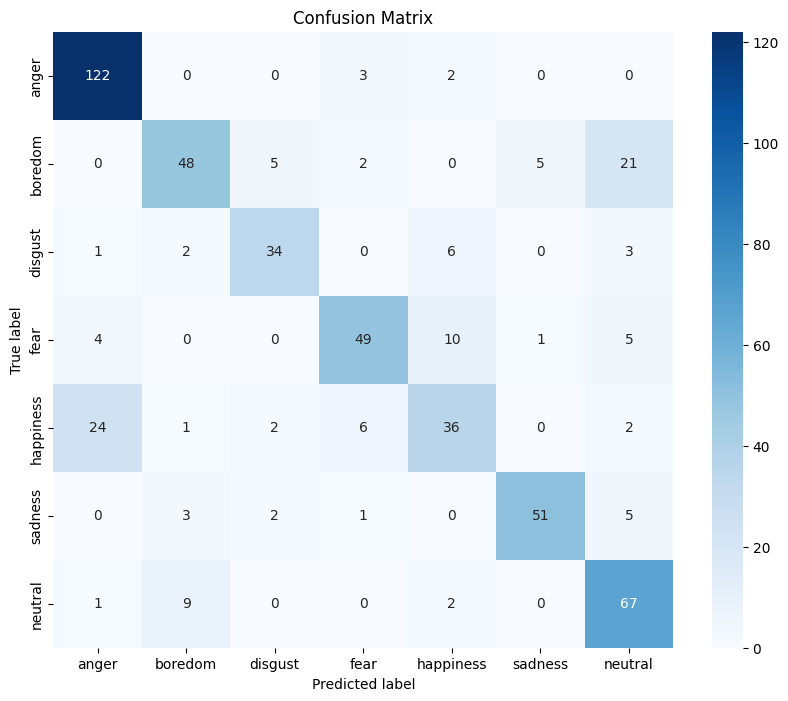

In [66]:
plot_confusion_matrix(all_y_true, all_y_pred, list(emotion_map.values()))

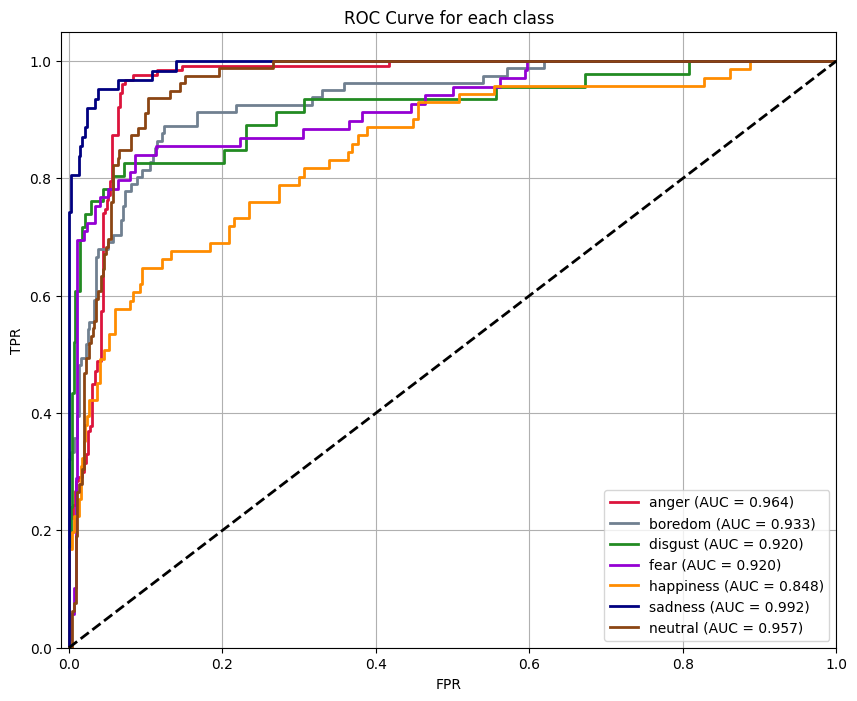

In [67]:
plot_roc_curve(all_y_true, all_y_score, num_classes, list(emotion_map.values()))